# Local Explanation of InceptionV3 with LIME

The notebook demonstrates how to use LIME - Local Interpretable Model-Agnostic Explanations to generate local explanations for predictions made by the Inception V3 model.

Inception V3 is a deep learning model pre-trained on the ImageNet dataset, used primarily for image classification tasks.

## Strengths
1. Explains individual predictions, which makes it easier to understand and visualize predictions.
2. It is Model-Agnostic and can be applied to any pre-trained model.
3. Visualization are intuitive. For example, visual explanations in the form of superpixels for images, which highlight areas of an image is super easy to understand.

## Limitations
1. It is computationally expensive since it perturbs the input data and evaluates the model. In this case, it took ~4.5 mins to finish a 1000 perturbations.

2. The quality of explanations depends on how well the image is segmented into superpixels. If the segmentation is poor, the explanation might not be meaningful.

## Potential Improvements
1. Run on GPU for faster computation.
2. Experiment with hyperparameters (for example, reducing `num_samples`) to strike a balance between performance and computation.

### Usage

Run the cells sequentially to preprocess the image (any image from unsplash can be used by providing the image address/url), generate predictions, and visualize the LIME explanations.

# Import Required Libraries

In [1]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=31d1090917336da824e16861cc121336e523e16728039f4363cfe89d1792de2f
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [2]:
import os
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import requests
import cv2
from skimage.segmentation import mark_boundaries
from skimage.color import gray2rgb
import lime
from lime import lime_image
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Download InceptionV3 Model and Sample(s) Image to test

Reference: https://keras.io/api/applications/inceptionv3/

Image urls can be found on Unsplash: https://unsplash.com/

In [3]:
# Load the Inception Model
inet_model = inc_net.InceptionV3()

def download_image(url, save_path):
    """Downloads the image from the url provided and saves at the given path"""
    response = requests.get(url)
    if response.status_code == 200:
        with open(save_path, 'wb') as f:
            f.write(response.content)
        print(f"Downloaded {save_path}")
    else:
        print(f"Failed to download {url}")

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [20]:
# Downloading sample image from Unsplash
image_url = "https://images.unsplash.com/photo-1592853625511-ad0edcc69c07?q=80&w=2669&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"
image_path = 'sample_image.png'

download_image(image_url, image_path)

Downloaded sample_image.png


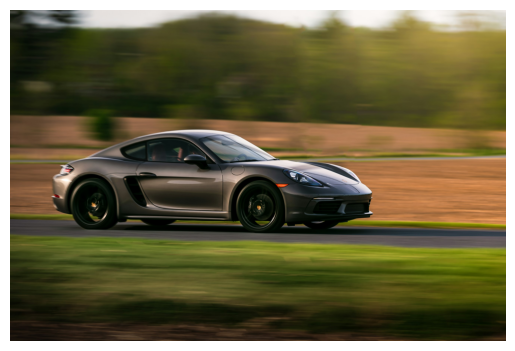

In [21]:
# Visualize the Image
img = cv2.imread('sample_image.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.show()

# Get Predictions from Inception

In [22]:
def transform_img_aspect_crop(path_list, target_size=(299, 299)):
    """Preprocesses a list of image file paths for input into the Inception V3 model"""
    out = []
    for img_path in path_list:
        # Load the image
        img = image.load_img(img_path)

        img.thumbnail((target_size[0], target_size[1]))  # Preserve aspect ratio

        # Central crop to the target size (299x299)
        width, height = img.size
        left = (width - target_size[0]) / 2
        top = (height - target_size[1]) / 2
        right = (width + target_size[0]) / 2
        bottom = (height + target_size[1]) / 2
        img = img.crop((left, top, right, bottom))

        img = img.resize(target_size)  # Resize to target size since I noticed minor size errors after just cropping

        # preprocess it for InceptionV3
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)

    return np.vstack(out)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
Prediction: sports_car
Confidence: 90.41%

Prediction: racer
Confidence: 2.73%

Prediction: car_wheel
Confidence: 1.45%

Prediction: beach_wagon
Confidence: 0.88%

Prediction: convertible
Confidence: 0.81%



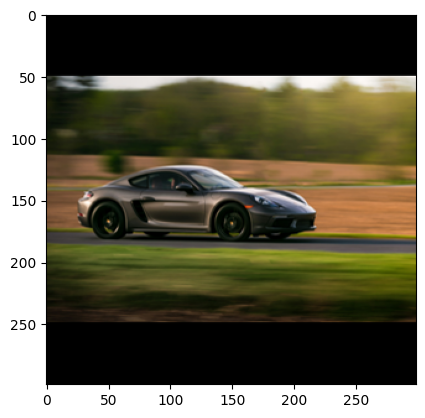

In [23]:
images = transform_img_aspect_crop(["sample_image.png"])

# The image is divided by 2 and 0.5 is added to it due to how Inception internally processes images
plt.imshow(images[0] / 2 + 0.5)
preds = inet_model.predict(images)

for x in decode_predictions(preds)[0]:
    print(f"Prediction: {x[1]}")
    print(f"Confidence: {x[2]*100:.2f}%\n")

We have a ~90.41% confidence score that the above provided image is that of a sports_car and 2.73% of it being a racer.

We will use LIME to understand what parts of the image are being focused on while making the above predictions.

# Setting up LIME

In [24]:
# Initialize LIME Explainer
explainer = lime_image.LimeImageExplainer()

# Generate explanation using LIME
explanation = explainer.explain_instance(
    images[0].astype('double'),
    inet_model.predict,
    top_labels=5,
    hide_color=0,
    num_samples=1000
)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

# Visualizing Results

Understanding the 1st predicition of the model i.e. sports_car with a confidence of 90.41%.

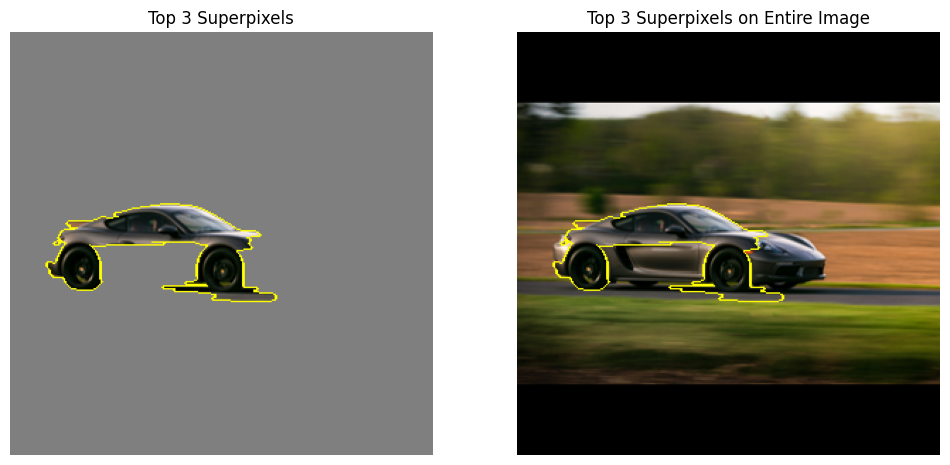

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Visualize superpixels i.e., top `num_features` areas contributing to the prediction
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=3, hide_rest=True)
ax[0].imshow(mark_boundaries(temp / 2 + 0.5, mask))
ax[0].set_title('Top 3 Superpixels')

# Visualize the entire image with explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=3, hide_rest=False)
ax[1].imshow(mark_boundaries(temp / 2 + 0.5, mask))
ax[1].set_title('Top 3 Superpixels on Entire Image')

for a in ax:
    a.axis('off')

plt.show()

This image on the left shows the most important 3 superpixels that contributed to the prediction. These regions are the ones that the model focuses on the most when predicting the top label i.e., sports_car.

We can see that the car wheels and the top of the car are important features contributing to the image being classified as a sports_car. Since the model is focusing on the right parts of the image (even though not all aspects of the car) we can say safely vouch about the models accuracy.

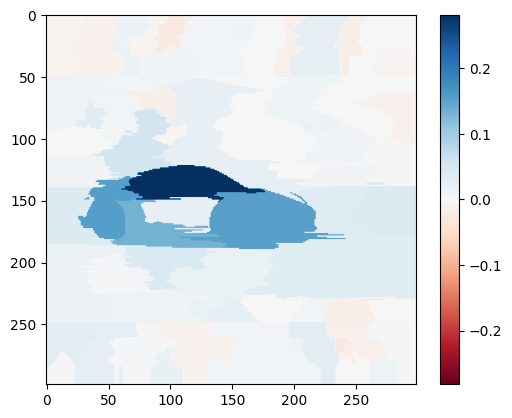

In [25]:
ind =  explanation.top_labels[0]

# Mapping each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)

plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

The heatmap visualizes the relative importance of each superpixel in contributing to the models prediction. The shape of the top of the car is the most weighted contributor.

A misleading part in this interpretability shows that there are random aspects of the background that the model is giving more weightage to as compared to the center of the car (car handle). Maybe this has something to do with the types of sports car images in the training dataset where it learned not to focus on the car center since wheels/top of the car are most clear indicator for a sports_car

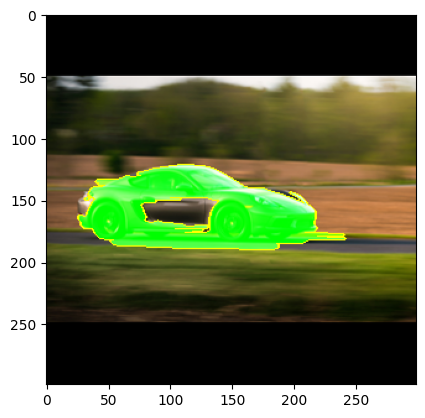

In [26]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Visualizing which parts of the image positively contributed to the presentation and which negatively.

Green: These areas positively contribute to the predicted class. Since this is mostly the region the car, the model is focusing on the right superpixels here.

Red: These areas negatively contribute to the prediction. In this image, there is no areas of the image contributing negatively!

Next let's analyze the the 2nd predicition of the model i.e. racer with a confidence of 2.73%.

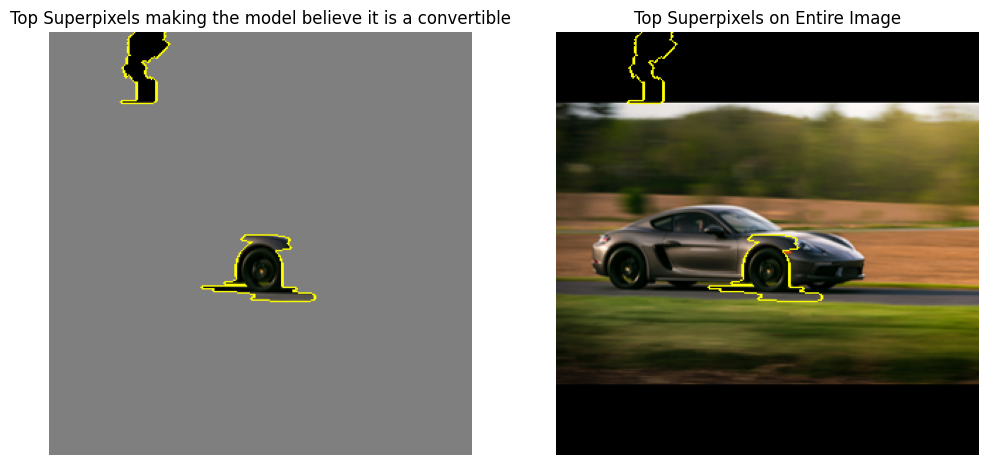

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=True, num_features=2, hide_rest=True)
ax[0].imshow(mark_boundaries(temp / 2 + 0.5, mask))
ax[0].set_title('Top Superpixels making the model believe it is a convertible')

# Visualize the entire image with explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=True, num_features=2, hide_rest=False)
ax[1].imshow(mark_boundaries(temp / 2 + 0.5, mask))
ax[1].set_title('Top Superpixels on Entire Image')

for a in ax:
    a.axis('off')

plt.show()

Weirdly enough, its the black part of the image (result of cropping the image and adding the borders to save the aspect ratio) that it contributing to the image. Is the balck background being mistaken for black wheels? This is misleading interpretability.

# Inception Interpretability for a complex image
Validating with another image to see if the wheels/top of the car are necessary for an image to be classified as a "car"

In [14]:
image_url = "https://images.unsplash.com/photo-1621872315369-1e13181a954e?q=80&w=2574&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"
image_path = 'sample_image_2.png'

download_image(image_url, image_path)

Downloaded sample_image_2.png


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
Prediction: pole
Confidence: 5.04%

Prediction: mountain_tent
Confidence: 4.75%

Prediction: lakeside
Confidence: 3.54%

Prediction: viaduct
Confidence: 3.52%

Prediction: unicycle
Confidence: 2.49%



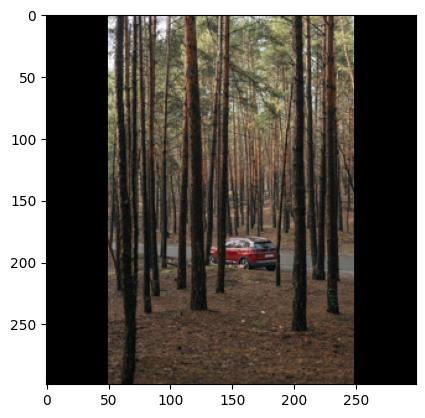

In [15]:
images = transform_img_aspect_crop(["sample_image_2.png"])

# The image is divided by 2 and 0.5 is added to it due to how Inception internally processes images
plt.imshow(images[0] / 2 + 0.5)
preds = inet_model.predict(images)

for x in decode_predictions(preds)[0]:
    print(f"Prediction: {x[1]}")
    print(f"Confidence: {x[2]*100:.2f}%\n")

For human eyes, it is very obvious that th image is of a car on the road surrounded by long trees.

However, the model is doing very poorly on classifying the image.
The model seems to be mistaking the long trees to be poles. Even though the confidence scores for the predictions are very low, it'll be interesting to see what makes the model predict this to be an image of a mountain_tent with 4.75% accuarcy since there is nothing resembling it in the image.

In [16]:
# Generate explanation using LIME
explanation = explainer.explain_instance(
    images[0].astype('double'),
    inet_model.predict,
    top_labels=5,
    hide_color=0,
    num_samples=1000
)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

Understanding Prediction 2 i.e. mountain_tent

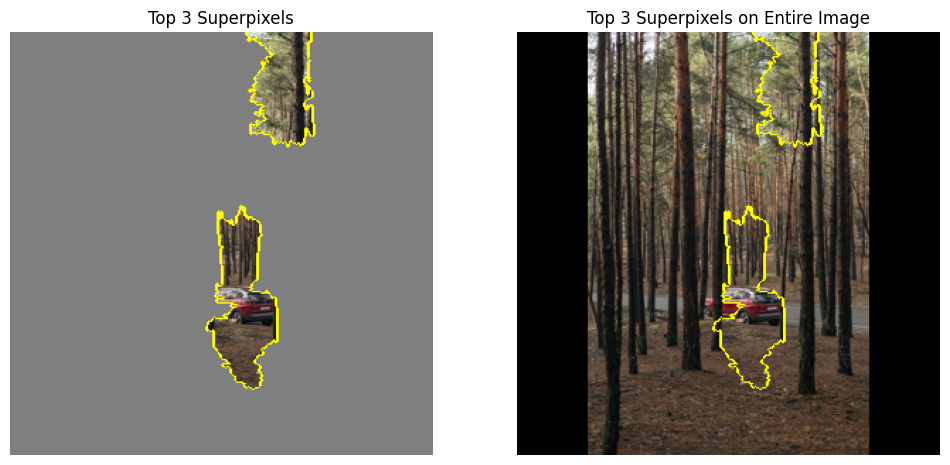

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Visualize superpixels i.e., top `num_features` areas contributing to the prediction
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=True, num_features=3, hide_rest=True)
ax[0].imshow(mark_boundaries(temp / 2 + 0.5, mask))
ax[0].set_title('Top 3 Superpixels')

# Visualize the entire image with explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=True, num_features=3, hide_rest=False)
ax[1].imshow(mark_boundaries(temp / 2 + 0.5, mask))
ax[1].set_title('Top 3 Superpixels on Entire Image')

for a in ax:
    a.axis('off')

plt.show()

We can see that it's absolute random parts of the image that the model is focusing on to make a prediction of mountain_tent that makes no sense to a user. Maybe the model has assigned "brownness" of the image to maountains and a splash of red+long pole like structures for a mountain tent but LIME interpretability clearly show us how not all predictions that come out of the model can be trusted blindly.